## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-03-15 10:30:18.726215


{1: 24.0,
 5: 25.3,
 10: 26.1,
 20: 27.0,
 30: 28.3,
 40: 30.1,
 50: 31.9,
 60: 33.7,
 70: 35.7,
 80: 38.2,
 90: 41.6,
 95: 44.5,
 99: 50.0}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-03-30 10:04:33.727540


{1: 7.8,
 5: 8.0,
 10: 8.1,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.8,
 70: 8.9,
 80: 9.1,
 90: 9.3,
 95: 9.5,
 99: 9.9}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-03-18 09:27:37.133234


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.norm(18.2, 19.4),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 3, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 47435.61it/s]


{1: 0.0007,
 5: 0.00107,
 10: 0.00135,
 20: 0.00175,
 30: 0.00214,
 40: 0.00259,
 50: 0.0031,
 60: 0.00379,
 70: 0.00504,
 80: 0.00805,
 90: 0.01188,
 95: 0.01444,
 99: 0.01997}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.07%',
 5: '0.107%',
 10: '0.135%',
 20: '0.175%',
 30: '0.214%',
 40: '0.259%',
 50: '0.31%',
 60: '0.379%',
 70: '0.504%',
 80: '0.805%',
 90: '1.188%',
 95: '1.444%',
 99: '1.997%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.7 billion',
 5: '27.0 billion',
 10: '34.0 billion',
 20: '43.8 billion',
 30: '53.6 billion',
 40: '65.2 billion',
 50: '77.5 billion',
 60: '95.2 billion',
 70: '126.8 billion',
 80: '201.7 billion',
 90: '297.5 billion',
 95: '364.7 billion',
 99: '502.8 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 923164.15it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.00038,
 70: 0.00057,
 80: 0.00092,
 90: 0.00176,
 95: 0.00296,
 99: 0.00815}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.025%',
 60: '0.038%',
 70: '0.057%',
 80: '0.092%',
 90: '0.176%',
 95: '0.296%',
 99: '0.815%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.4 billion',
 60: '9.5 billion',
 70: '14.3 billion',
 80: '23.1 billion',
 90: '44.2 billion',
 95: '74.4 billion',
 99: '204.1 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~7.0 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 19.8 log FLOP (~64.3 quintillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.6 million).
* This doubles every 3.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 32.4 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 13.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which costs 12.

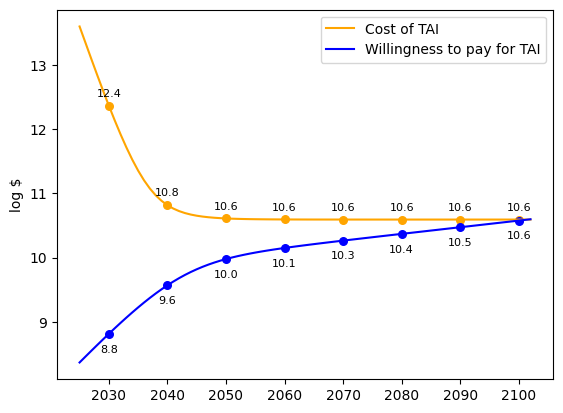



## SAMPLE RUN 2 ##

In this simulation:
* It takes 24.1 log FLOP (~1.3 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.5 log FLOP (~317.7 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.4 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.018x per year.
---
2025 - TAI takes 24.1 logFLOP which costs 5.5 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 7 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- thi

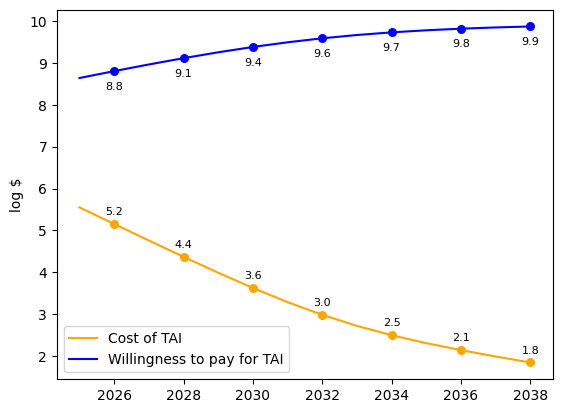



## SAMPLE RUN 3 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.8 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~3.7 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.2 million).
* This doubles every 2.9 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.039x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 2 years)
-- 

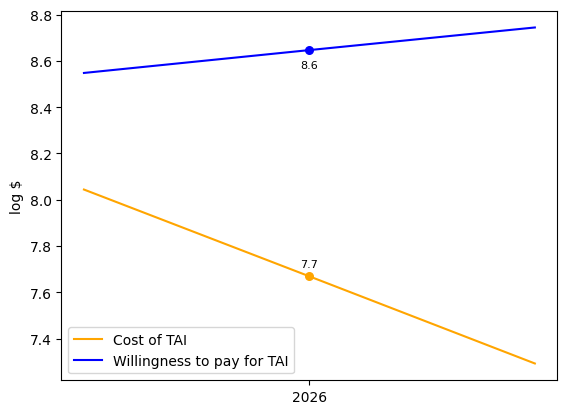



## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.75it/s]


Shuffling data...
Writing data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 712.78it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2032',
 '15%: 2033',
 '20%: 2035',
 '25%: 2036',
 '35%: 2039',
 '50%: 2045',
 '60%: 2051',
 '75%: 2076',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 5 years from now',
 '10%: 7 years from now',
 '15%: 8 years from now',
 '20%: 10 years from now',
 '25%: 11 years from now',
 '35%: 14 years from now',
 '50%: 20 years from now',
 '60%: 26 years from now',
 '75%: 51 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 37 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.2%
2026-2027: 0.5%
2028-2030: 4.5%
2030-2034: 16.5%
2035-2039: 16.7%
2040-2049: 21.7%
2050-2059: 10.3%
2060-2069: 4.9%
2070-2079: 2.8%
2080-2089: 1.3%
2090-2099: 0.5%
2100-2109: 0.5%
2110-2119: 0.6



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~25.9 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.2 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.8 trillion) 80% CI 13.4 (~26.2 trillion) - 13.4 (~27.4 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.4 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.2 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.0 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.0 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.6 trillion) 80% CI 13.4 (~27.5 trillion) - 13.5 (~29.9 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.3 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.7 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~29.9 trillion) 80% CI 13.5 (~28.4 trillion) - 13.5 (~31.6 trillion)
Year: 2034 - GDP log 2024$USD 13.

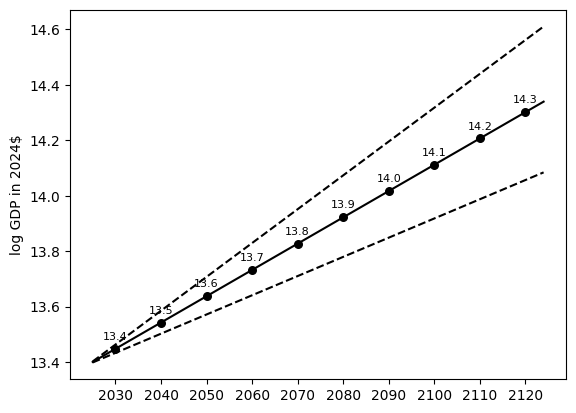

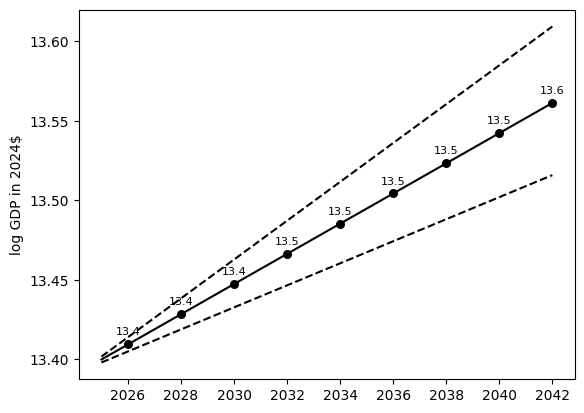



## Willingness to Pay Over Time ##
Year: 2025 - willingness log 2024$USD per year 8.6 (~375.5 million) 80% CI 8.3 (~193.4 million) - 9.0 (~959.7 million)
Year: 2026 - willingness log 2024$USD per year 8.7 (~541.4 million) 80% CI 8.5 (~320.7 million) - 9.1 (~1.3 billion)
Year: 2027 - willingness log 2024$USD per year 8.9 (~772.9 million) 80% CI 8.7 (~525.2 million) - 9.2 (~1.7 billion)
Year: 2028 - willingness log 2024$USD per year 9.0 (~1.1 billion) 80% CI 8.9 (~843.3 million) - 9.3 (~2.2 billion)
Year: 2029 - willingness log 2024$USD per year 9.2 (~1.5 billion) 80% CI 9.1 (~1.3 billion) - 9.5 (~2.9 billion)
Year: 2030 - willingness log 2024$USD per year 9.3 (~2.0 billion) 80% CI 9.3 (~2.0 billion) - 9.6 (~3.8 billion)
Year: 2031 - willingness log 2024$USD per year 9.4 (~2.7 billion) 80% CI 9.4 (~2.8 billion) - 9.7 (~4.9 billion)
Year: 2032 - willingness log 2024$USD per year 9.5 (~3.4 billion) 80% CI 9.6 (~3.7 billion) - 9.8 (~6.2 billion)
Year: 2033 - willingness log 2024$USD per y

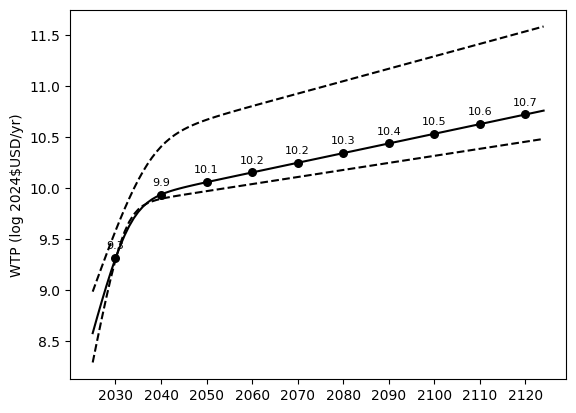

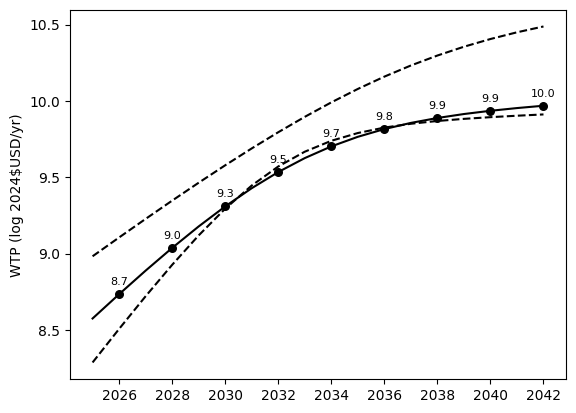



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 31.6 (~39.8 nonillion) 80% CI 26.9 (~794.3 septillion) - 38.3 (~208.9 thousand decillion)
Year: 2026 - logFLOP needed for TAI 31.3 (~20.7 nonillion) 80% CI 26.6 (~417.9 septillion) - 38.1 (~128.7 thousand decillion)
Year: 2027 - logFLOP needed for TAI 31.0 (~10.8 nonillion) 80% CI 26.3 (~219.5 septillion) - 37.9 (~79.3 thousand decillion)
Year: 2028 - logFLOP needed for TAI 30.8 (~5.7 nonillion) 80% CI 26.1 (~117.1 septillion) - 37.7 (~48.8 thousand decillion)
Year: 2029 - logFLOP needed for TAI 30.5 (~3.1 nonillion) 80% CI 25.8 (~64.3 septillion) - 37.5 (~30.1 thousand decillion)
Year: 2030 - logFLOP needed for TAI 30.3 (~1.8 nonillion) 80% CI 25.6 (~37.0 septillion) - 37.3 (~18.5 thousand decillion)
Year: 2031 - logFLOP needed for TAI 30.0 (~1.1 nonillion) 80% CI 25.4 (~22.9 septillion) - 37.1 (~11.4 thousand decillion)
Year: 2032 - logFLOP needed for TAI 29.9 (~760.2 octillion) 80

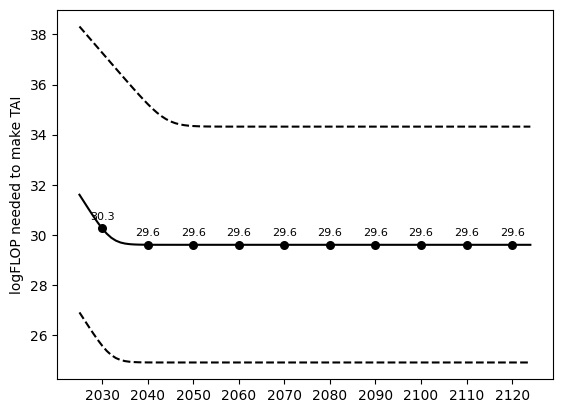

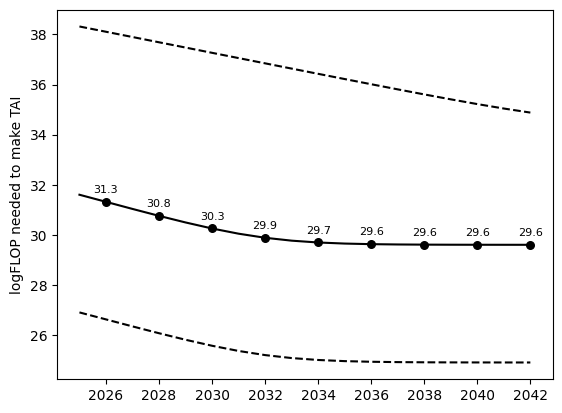



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.8 (~6.6 quintillion) 80% CI 18.5 (~3.3 quintillion) - 19.1 (~13.7 quintillion)
Year: 2026 - logFLOP per 2024$1USD 18.9 (~8.8 quintillion) 80% CI 18.7 (~4.5 quintillion) - 19.2 (~17.7 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.1 (~11.6 quintillion) 80% CI 18.8 (~6.1 quintillion) - 19.4 (~22.8 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~15.4 quintillion) 80% CI 18.9 (~8.3 quintillion) - 19.5 (~29.4 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~20.3 quintillion) 80% CI 19.1 (~11.3 quintillion) - 19.6 (~37.9 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~26.9 quintillion) 80% CI 19.2 (~15.4 quintillion) - 19.7 (~48.8 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.6 (~35.5 quintillion) 80% CI 19.3 (~20.9 quintillion) - 19.8 (~62.9 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.7 (~47.0 quintillion) 80% CI 19.5 (~28.5 quintillion) - 19.9 (~81.1 quintillion)
Year: 

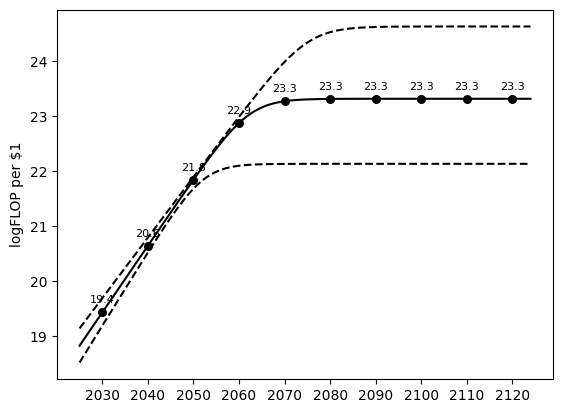

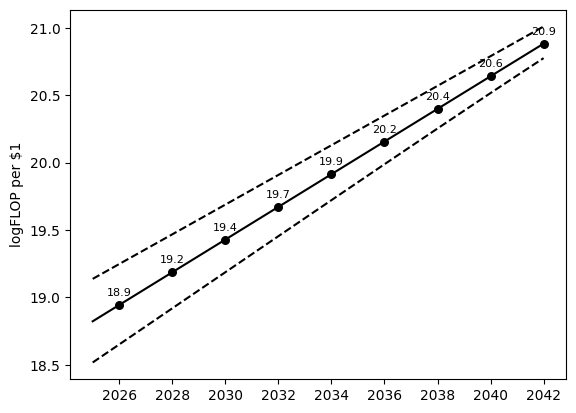



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

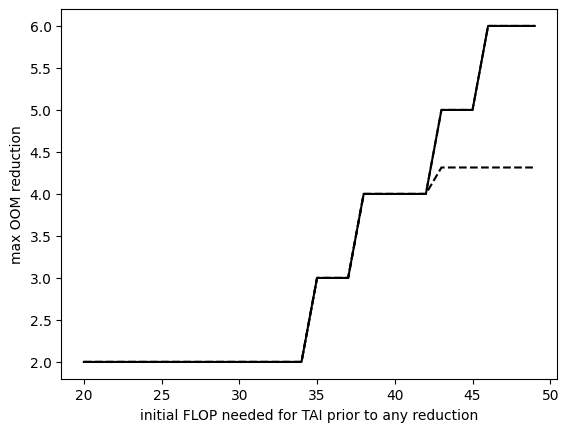



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 21 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 22 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 23 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 24 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 25 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 26 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 27 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 28 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 29 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 30 -> algo doubling rate 1.48yrs (80% CI: 2.13 to 2.13)
TAI log FLOP 31 -> algo doubling rate 1.03yrs (80% CI: 1.63 to 1.63)
TAI log FLOP 32 -> algo doubling rate 1.03yrs (80% CI: 1.13 to 1.13)
TAI log FLOP 33 -> algo doubling rate 1.03yrs (80%

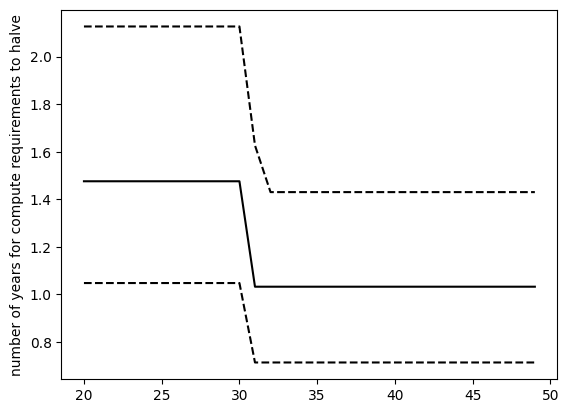



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 12.8 log 2024$USD to buy TAI (~6.0 trillion) 80% CI 8.4 (~241.4 million) - 19.2 (~15.2 quintillion)
Year: 2026 - 12.4 log 2024$USD to buy TAI (~2.4 trillion) 80% CI 8.0 (~93.3 million) - 18.9 (~7.3 quintillion)
Year: 2027 - 12.0 log 2024$USD to buy TAI (~928.5 billion) 80% CI 7.6 (~36.0 million) - 18.5 (~3.5 quintillion)
Year: 2028 - 11.6 log 2024$USD to buy TAI (~371.5 billion) 80% CI 7.1 (~14.1 million) - 18.2 (~1.7 quintillion)
Year: 2029 - 11.2 log 2024$USD to buy TAI (~153.2 billion) 80% CI 6.8 (~5.7 million) - 17.9 (~794.3 quadrillion)
Year: 2030 - 10.8 log 2024$USD to buy TAI (~66.4 billion) 80% CI 6.4 (~2.4 million) - 17.6 (~379.8 quadrillion)
Year: 2031 - 10.5 log 2024$USD to buy TAI (~31.2 billion) 80% CI 6.0 (~1.1 million) - 17.3 (~181.6 quadrillion)
Year: 2032 - 10.2 log 2024$USD to buy TAI (~16.2 billion) 80% CI 5.7 (~551.0 thousand) - 16.9 (~86.9 quadrillion)
Year: 203

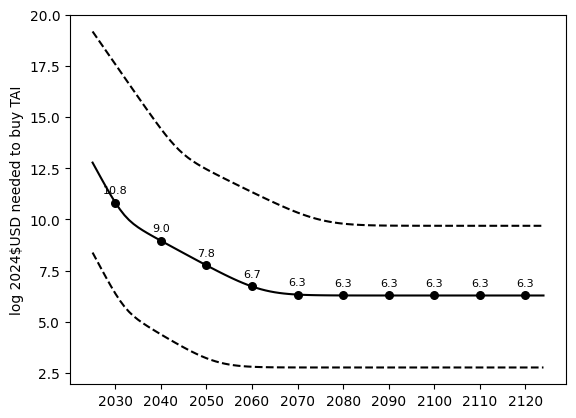

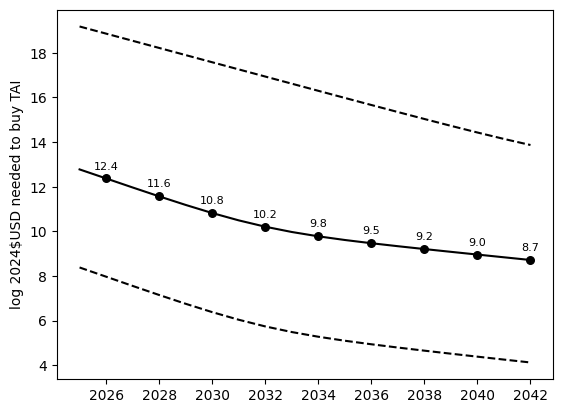



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.4 (~2.5 octillion) 80% CI 26.8 (~636.1 septillion) - 28.1 (~13.2 octillion)
Year: 2026 - max log FLOP 27.7 (~4.8 octillion) 80% CI 27.2 (~1.4 octillion) - 28.4 (~22.5 octillion)
Year: 2027 - max log FLOP 28.0 (~9.0 octillion) 80% CI 27.5 (~3.2 octillion) - 28.6 (~38.5 octillion)
Year: 2028 - max log FLOP 28.2 (~16.7 octillion) 80% CI 27.8 (~7.0 octillion) - 28.8 (~65.3 octillion)
Year: 2029 - max log FLOP 28.5 (~30.6 octillion) 80% CI 28.2 (~14.9 octillion) - 29.0 (~110.2 octillion)
Year: 2030 - max log FLOP 28.7 (~54.7 octillion) 80% CI 28.5 (~30.2 octillion) - 29.3 (~184.8 octillion)
Year: 2031 - max log FLOP 29.0 (~95.2 octillion) 80% CI 28.8 (~58.4 octillion) - 29.5 (~307.2 octillion)
Year: 2032 - max log FLOP 29.2 (~160.6 octillion) 80% CI 29.0 (~105.8 octillion) - 29.7 (~505.4 octillion)
Year: 2033 - max log FLOP 29.4 (~262.0 octillion) 80% CI 29.3 (~180.0 octillion) - 29.9 (~821.4 octillion)
Year: 2034 - max log FLOP 

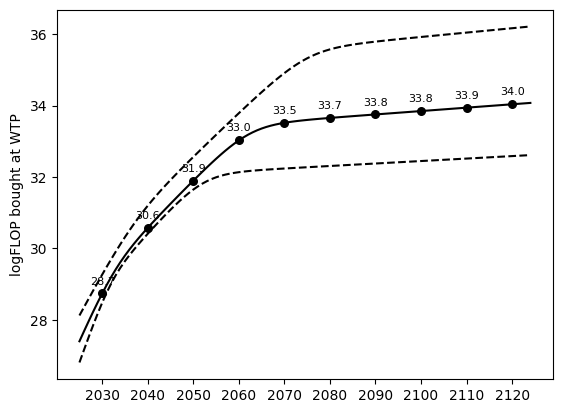

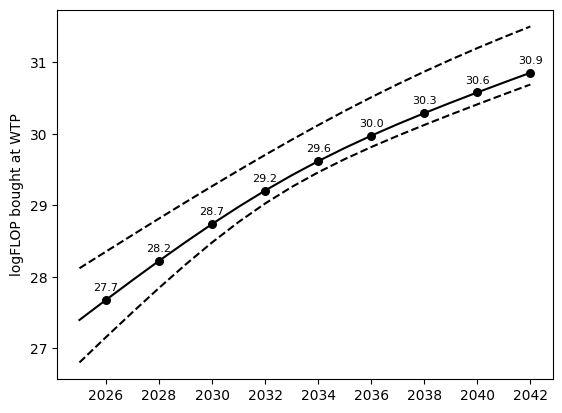



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.4 (~2.5 octillion) 80% CI 26.8 (~636.1 septillion) - 28.1 (~13.2 octillion)
Year: 2026 - max log effective 2024-FLOP 28.0 (~9.1 octillion) 80% CI 27.4 (~2.3 octillion) - 28.8 (~59.5 octillion)
Year: 2027 - max log effective 2024-FLOP 28.5 (~33.1 octillion) 80% CI 27.9 (~8.2 octillion) - 29.4 (~268.0 octillion)
Year: 2028 - max log effective 2024-FLOP 29.1 (~116.6 octillion) 80% CI 28.5 (~28.7 octillion) - 30.1 (~1.2 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.6 (~391.3 octillion) 80% CI 29.0 (~96.5 octillion) - 30.7 (~5.3 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.1 (~1.2 nonillion) 80% CI 29.5 (~306.7 octillion) - 31.4 (~23.4 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.5 (~3.4 nonillion) 80% CI 30.0 (~903.9 octillion) - 32.0 (~100.7 nonillion)
Year: 2032 - max log effective 2024-FLOP 30.9 (~8.4 nonillion) 80% CI 30.4 

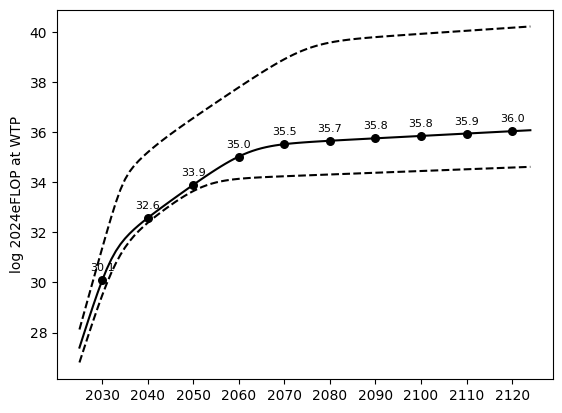

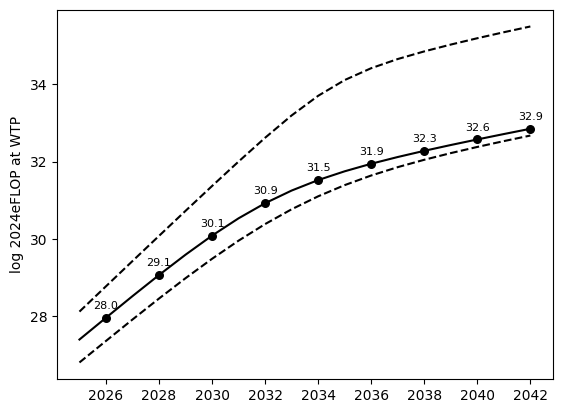


## TAI FLOP SIZE ##
{1: 24.0,
 5: 25.1,
 10: 25.9,
 20: 26.9,
 30: 28.0,
 40: 29.9,
 50: 31.6,
 60: 33.9,
 70: 35.9,
 80: 38.32,
 90: 42.11000000000001,
 95: 45.2,
 99: 49.004999999999995}


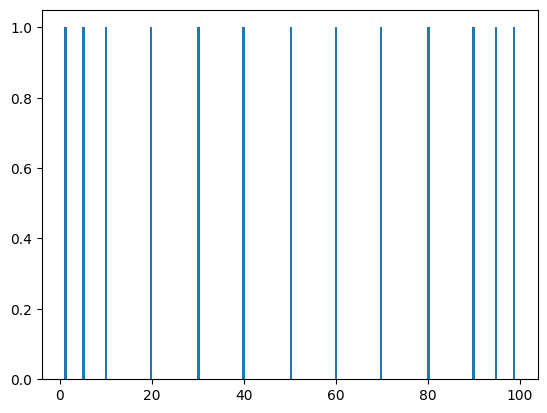



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 2.2524026897144425,
 5: 2.9795004056136114,
 10: 3.5298365197040367,
 20: 4.314677649407416,
 30: 5.150804863025631,
 40: 5.835539713125544,
 50: 6.481310183233251,
 60: 7.441893239719929,
 70: 8.518438243963578,
 80: 9.969358942738547,
 90: 12.591349326764863,
 95: 14.391094812333945,
 99: 19.010285593087023}


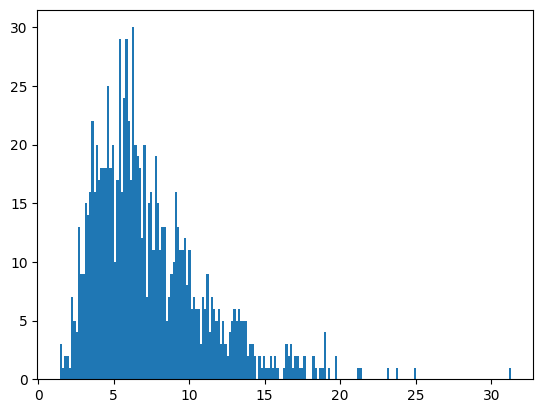



## MIN ALGO DOUBLING RATE ##
{1: 0.39774478852735223,
 5: 0.48712957194432804,
 10: 0.5964167094773336,
 20: 0.7138325951961492,
 30: 0.7961159389886384,
 40: 0.9076842202713586,
 50: 1.032367156977143,
 60: 1.149292877409253,
 70: 1.2706001791549062,
 80: 1.4300256643648543,
 90: 1.7038954415764922,
 95: 2.041308440355053,
 99: 2.5397197332486594}


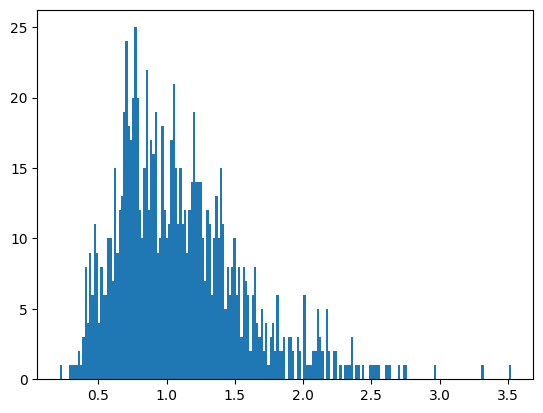



## MAX ALGO DOUBLING RATE ##
{1: 0.5292043665228686,
 5: 0.7301554190366571,
 10: 0.8735312901754347,
 20: 1.0477605223847302,
 30: 1.1787227238695361,
 40: 1.314888929049583,
 50: 1.4756303154729096,
 60: 1.6453898116685832,
 70: 1.8605864695972067,
 80: 2.126361134036612,
 90: 2.51326615511478,
 95: 2.9336385813441526,
 99: 3.9735379062964853}


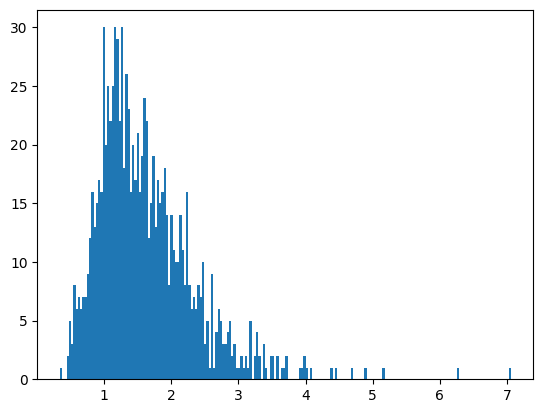



## INITIAL FLOP PER DOLLAR ##
{1: 17.962069762502544,
 5: 18.240379301939647,
 10: 18.357502613864032,
 20: 18.517292455114298,
 30: 18.622538933831137,
 40: 18.71848987218575,
 50: 18.822809962676004,
 60: 18.899777453970774,
 70: 19.015431011930282,
 80: 19.137572341978604,
 90: 19.274690762743433,
 95: 19.396263849324217,
 99: 19.593440623406767}


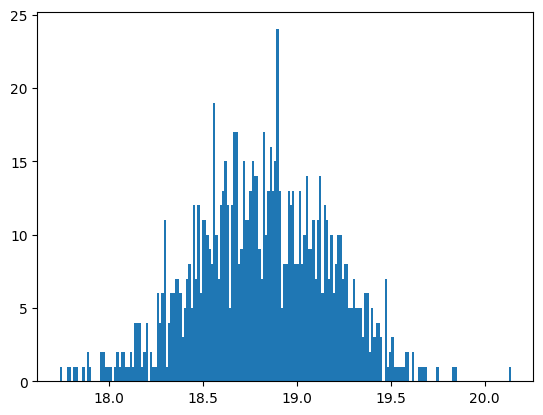



## FLOP HALVING RATE ##
{1: 1.763115821674234,
 5: 1.9782957791577007,
 10: 2.108085399916302,
 20: 2.246633207911044,
 30: 2.3279042206250873,
 40: 2.4005038699003887,
 50: 2.4820590065822588,
 60: 2.553792744368363,
 70: 2.6263361700598904,
 80: 2.732303885845489,
 90: 2.873673604746336,
 95: 2.967070069598292,
 99: 3.1801166026165903}


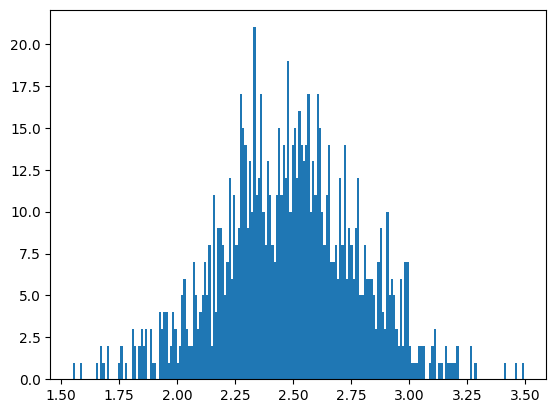



## MAX FLOP PER DOLLAR ##
{1: 19.84810279855266,
 5: 20.958866092613253,
 10: 21.56040928679451,
 20: 22.130880432150313,
 30: 22.60327586406935,
 40: 22.96997398342493,
 50: 23.31458094168875,
 60: 23.774217542816896,
 70: 24.18510186876859,
 80: 24.629684540817138,
 90: 25.441824484133686,
 95: 25.953462608309565,
 99: 26.98634604041003}


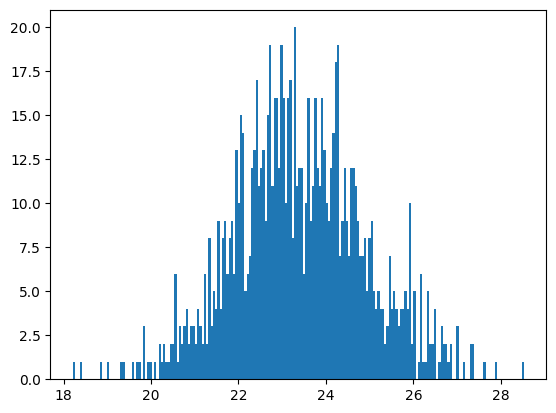



## INITIAL PAY ##
{1: 7.9,
 5: 8.0,
 10: 8.1,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.9,
 80: 9.0,
 90: 9.3,
 95: 9.504999999999995,
 99: 9.8}


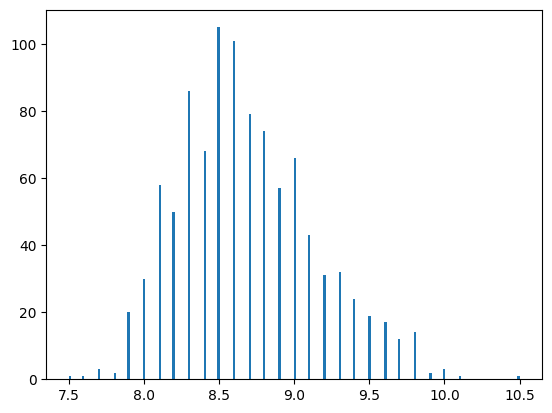



## INITIAL GDP ##
{1: 24818180478242.086,
 5: 24908301244983.625,
 10: 24950992593168.016,
 20: 25004365403996.01,
 30: 25045353714706.562,
 40: 25080995810019.723,
 50: 25112533391051.758,
 60: 25148232935458.99,
 70: 25178906580502.156,
 80: 25217165744281.367,
 90: 25289116082886.37,
 95: 25337053550302.523,
 99: 25420483384414.914}


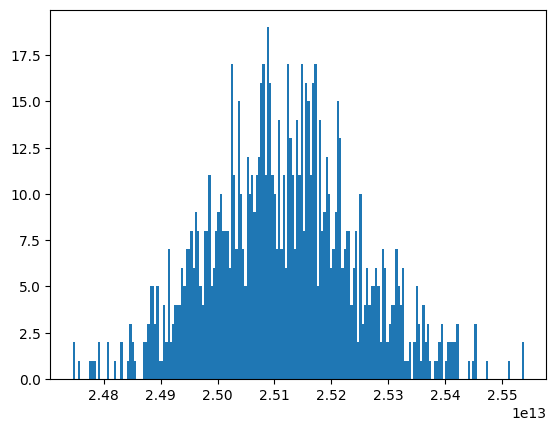



## GDP GROWTH ##
{1: 1.005,
 5: 1.0099831795516898,
 10: 1.0129301677896239,
 20: 1.0160871585372693,
 30: 1.0183403844125176,
 40: 1.0202941397431509,
 50: 1.0220933162140247,
 60: 1.0243315436498415,
 70: 1.0260706281441012,
 80: 1.0285199922212114,
 90: 1.032042452180946,
 95: 1.03413746693647,
 99: 1.038872849106914}


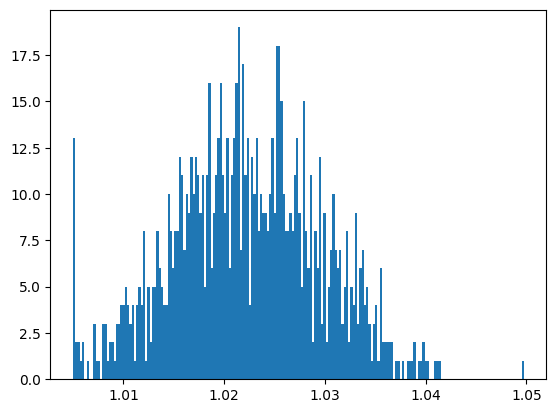



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00026338377942533835,
 60: 0.0004118417811838243,
 70: 0.0006151041307975976,
 80: 0.0009454569184675242,
 90: 0.0015863947732114975,
 95: 0.0029283640950801323,
 99: 0.007699470294710932}


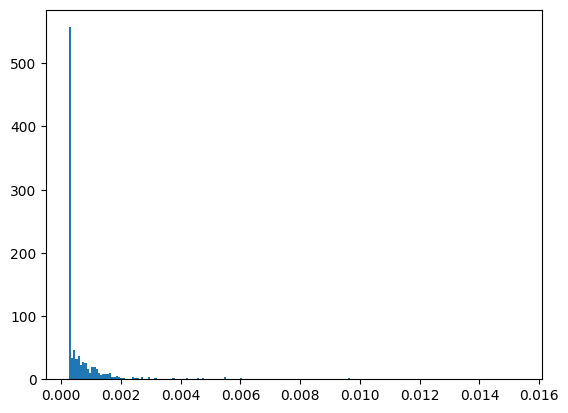



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 1.0009414271974233,
 10: 1.1515206403765035,
 20: 1.3169507998030543,
 30: 1.4754946800218791,
 40: 1.6330228479437257,
 50: 1.772738837257375,
 60: 1.9204517657454239,
 70: 2.132608496494616,
 80: 2.3418195415133685,
 90: 2.7113510681084416,
 95: 3.1181095013932425,
 99: 3.771615920454511}


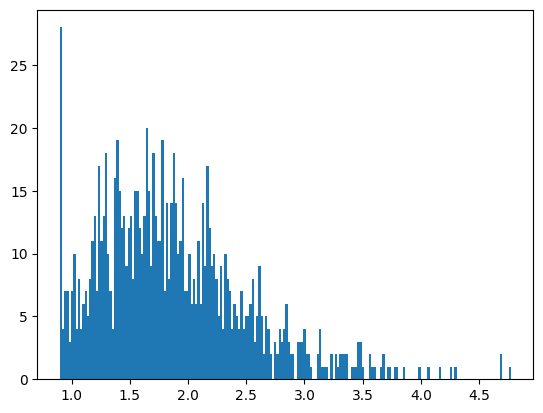





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 3,
 30: 3,
 40: 3,
 50: 3,
 60: 3,
 70: 4,
 80: 4,
 90: 5,
 95: 7,
 99: 15}
## Chance of nonscaling delay ##


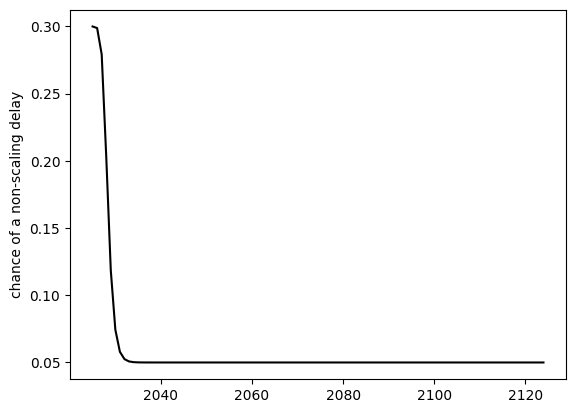

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - ch

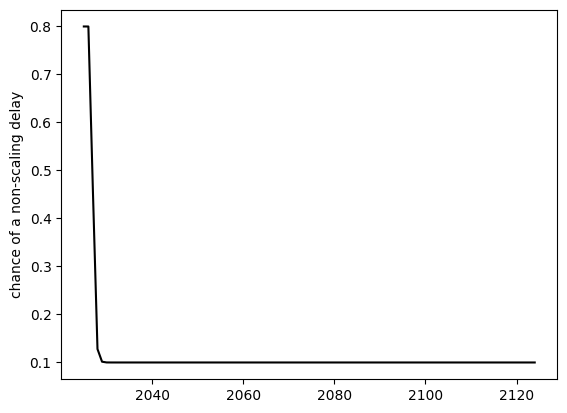

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 46%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

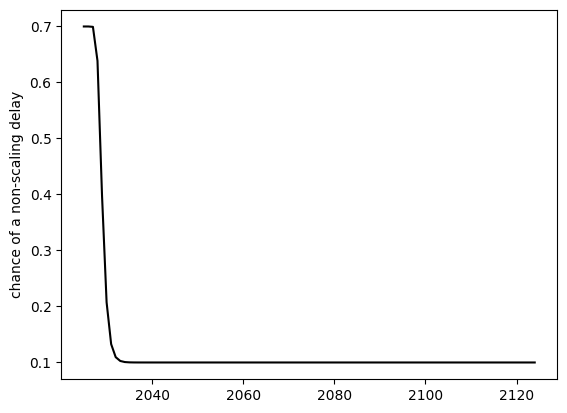

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

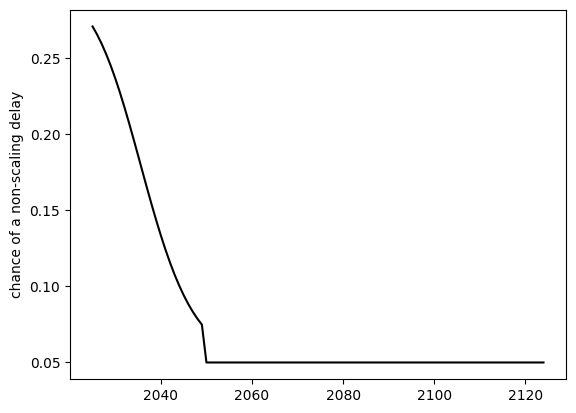

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2035

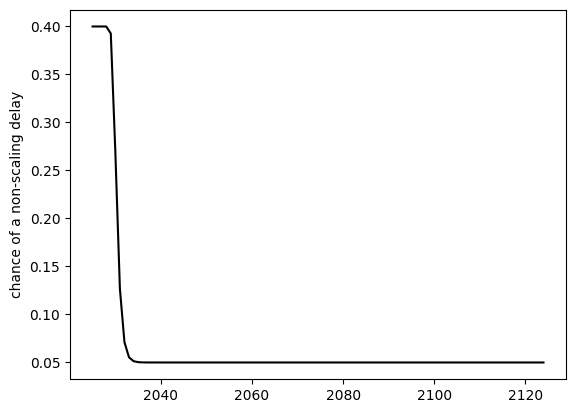

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - 

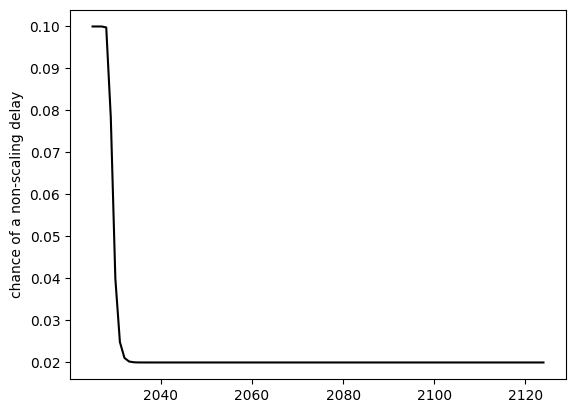

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 4%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - cha

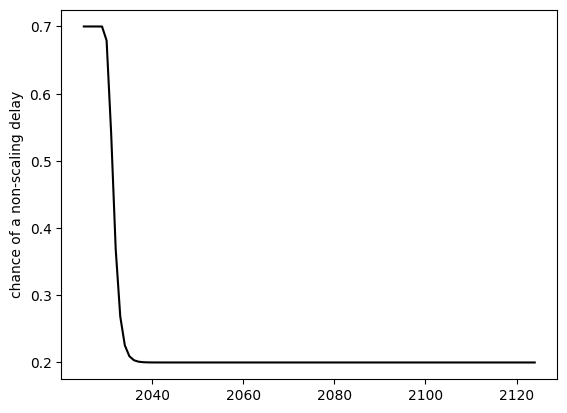

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 54%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2035

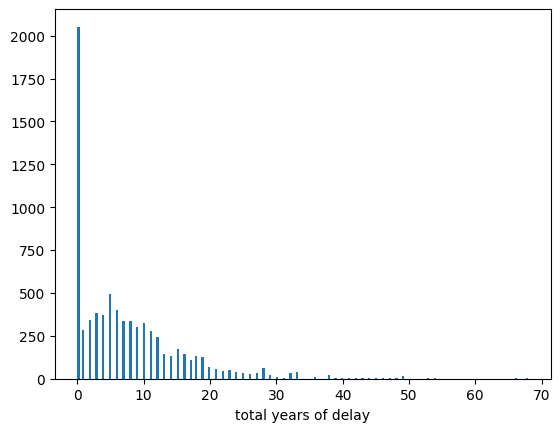

In [13]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 33.1 log FLOP (~1.3 decillion) for transformative capabilities.
* Every 2.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~13.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~872.2 million).
* This doubles every 3.2 year to a max of 0.026982% of GDP (initially ~6.8 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 33.1 logFLOP which costs 14.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 13.8 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 32.9 logFLOP which costs 13.5 log 2025$USD to buy vs. WTP at 9.1 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 32.8 logFLOP which costs 1

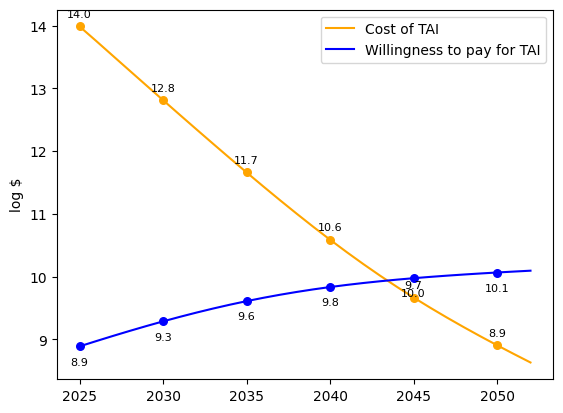

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 26.1 log FLOP (~125.9 septillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.0 million).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 26.1 logFLOP which costs 6.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -> N

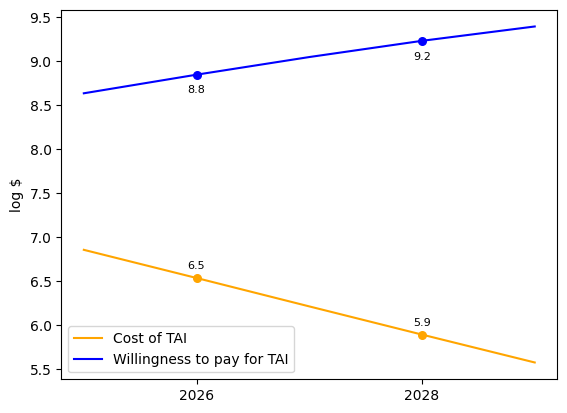

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~125.2 million).
* This doubles every 2.5 year to a max of 0.089104% of GDP (initially ~22.4 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 26.0 logFLOP which costs 7.2 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 year

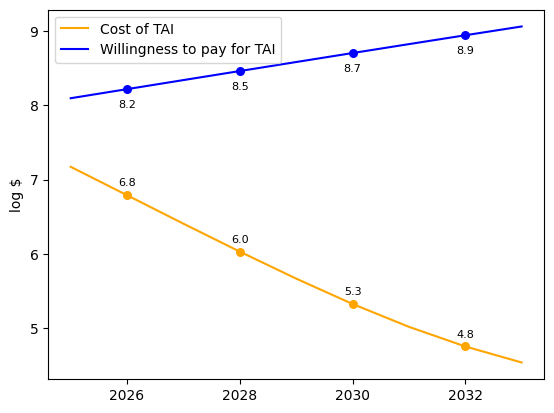

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~185.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~393.7 million).
* This doubles every 2.1 year to a max of 0.142493% of GDP (initially ~35.7 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 27.1 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 26.9 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2793 ->

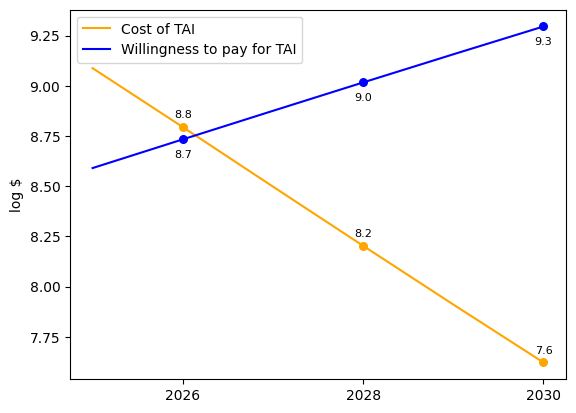

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~6.4 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.0 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.015x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 27.5 logFLOP which costs 8.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue d

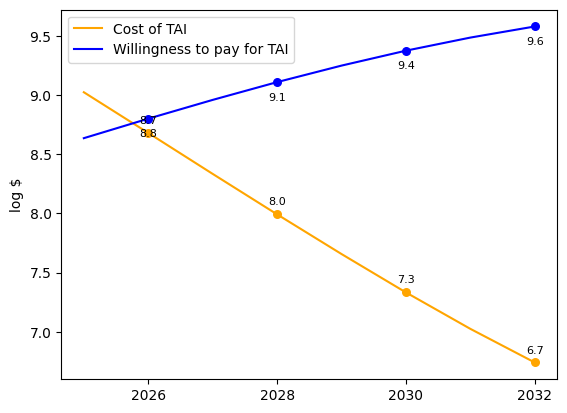

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 30.4 log FLOP (~2.5 nonillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.4 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~275.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~157.3 million).
* This doubles every 1.7 year to a max of 0.083697% of GDP (initially ~21.0 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 30.4 logFLOP which costs 11.5 log 2025$USD to buy vs. WTP at 8.2 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 30.3 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 30.1 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 29.9 logFLOP which costs

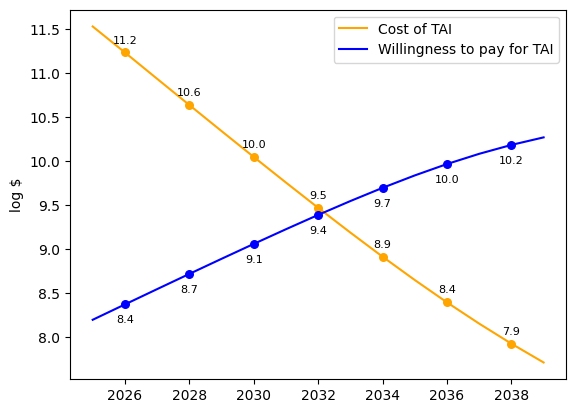

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.1 log FLOP (~127.3 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.8 year to a max of 0.254843% of GDP (initially ~63.7 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)

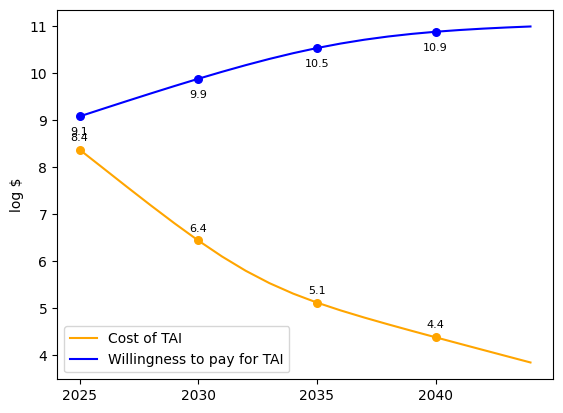

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 39.6 log FLOP (~4.0 million decillion) for transformative capabilities.
* Every 4.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1.7 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~387.9 million).
* This doubles every 1.3 year to a max of 0.060421% of GDP (initially ~15.1 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 39.6 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 39.5 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 39.5 logFLOP which costs 20.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 39.4 logFLOP whic

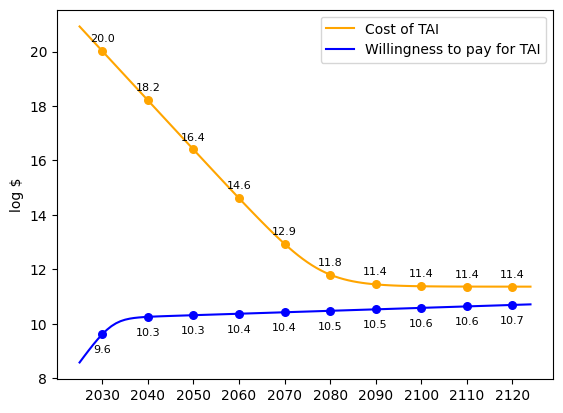

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 37.4 log FLOP (~25.1 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.9 log FLOP (~7.6 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 37.4 logFLOP which costs 18.7 log 2025$USD to buy vs. WTP at 8.3 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 37.2 logFLOP which costs 18.3 log 2025$USD to buy vs. WTP at 8.4 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 36.9 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 36.7 logFLOP which c

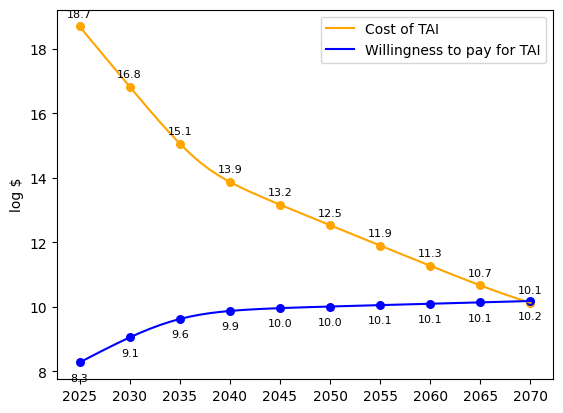

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~930.8 sextillion) per 2025$USD.
* We are initially willing to pay 7.8 log 2025$USD (~62.5 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 7.8 (buys 26.5 log FLOP or 26.5 2025-log-eFLOP)
2026 - TAI takes 26.3 logFLOP which costs 7.5 log 2025$USD to buy vs. WTP at 8.0 (buys 26.8 log FLOP or 27.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling del

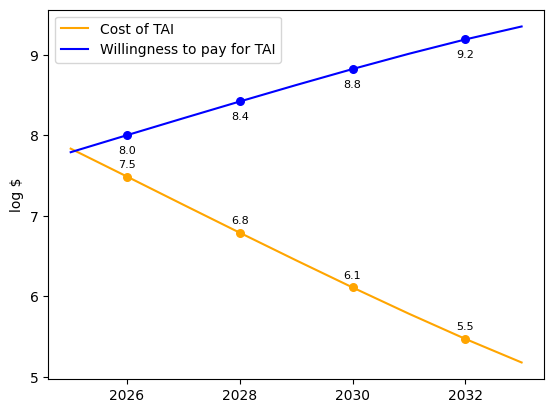

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 26.6 log FLOP (~398.1 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.2 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~531.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.6 million).
* This doubles every 1.5 year to a max of 0.164566% of GDP (initially ~41.6 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 26.6 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.3 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 y

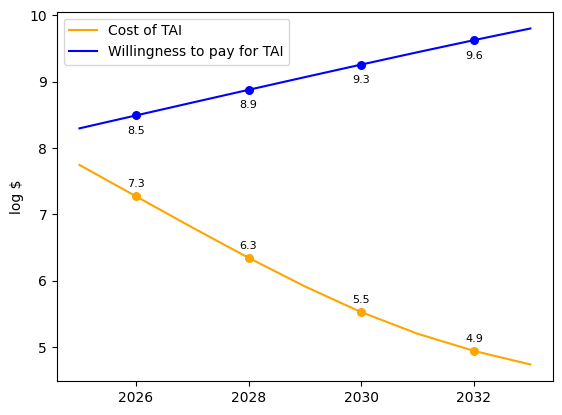

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.2 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.8 log FLOP (~7.0 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.9 million).
* This doubles every 1.7 year to a max of 0.026057% of GDP (initially ~6.5 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.3 log 2025$USD to buy vs. WTP at 8.5 (buys 27.2 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2988 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (tota

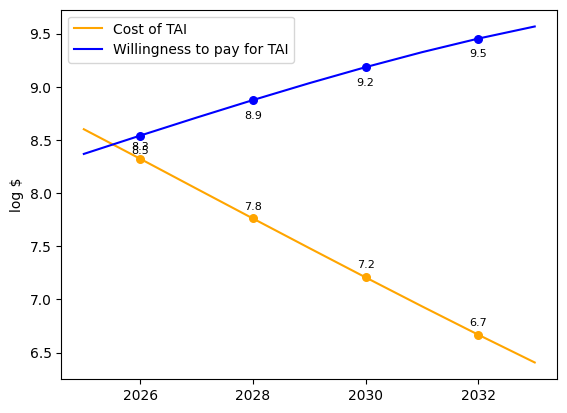

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~463.9 million).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 38.0 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 37.7 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.8 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 18.8 log 2025$USD to buy vs. WTP at 9.0 (buys 27.7 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 37.2 logFLOP which

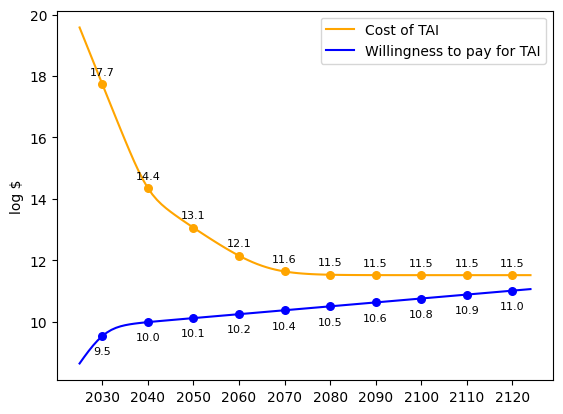

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 34.0 log FLOP (~10.0 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~13.1 septillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~124.1 million).
* This doubles every 1.7 year to a max of 0.033888% of GDP (initially ~8.6 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 34.0 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 33.6 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 8.3 (buys 27.2 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 33.2 logFLOP which costs 14.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.8 logFLOP which costs

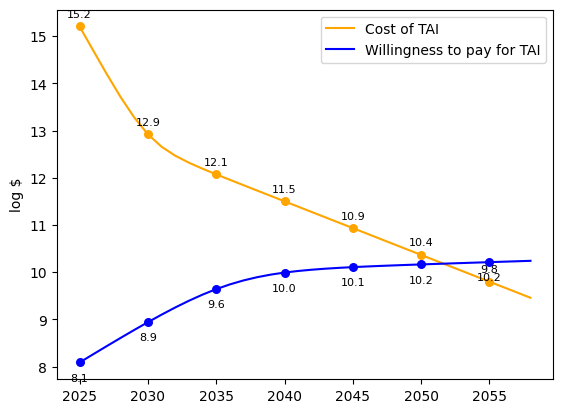

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 42.5 log FLOP (~3.2 billion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 3.3 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~31.4 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.3 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~618.7 million).
* This doubles every 1.5 year to a max of 0.126914% of GDP (initially ~31.9 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 42.5 logFLOP which costs 23.0 log 2025$USD to buy vs. WTP at 8.8 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 42.2 logFLOP which costs 22.6 log 2025$USD to buy vs. WTP at 9.0 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 42.0 logFLOP which costs 22.2 log 2025$USD to buy vs. WTP at 9.2 (buys 28.9 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 41.7 logFLOP w

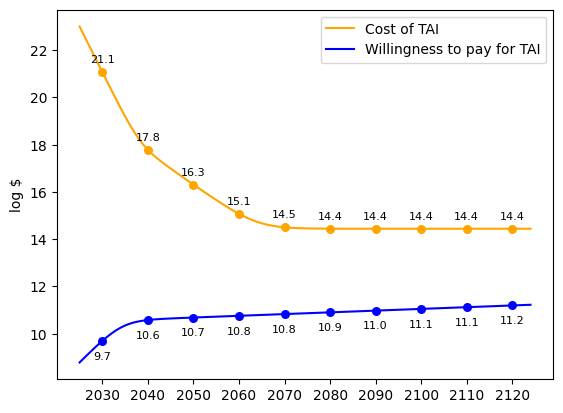

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 37.0 log FLOP (~10.0 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.5 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~758.7 quintillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~312.0 million).
* This doubles every 1.6 year to a max of 0.091947% of GDP (initially ~23.2 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 37.0 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 36.6 logFLOP which costs 17.6 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 36.3 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 35.9 logFLOP

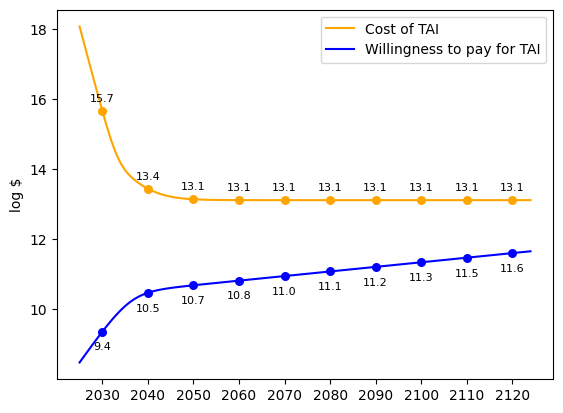

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 32.4 log FLOP (~251.2 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~763.2 million).
* This doubles every 1.9 year to a max of 0.076743% of GDP (initially ~19.5 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 32.4 logFLOP which costs 13.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 32.2 logFLOP which costs 13.3 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 32.1 logFLOP which costs 13.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 31.9 logFLOP which cos

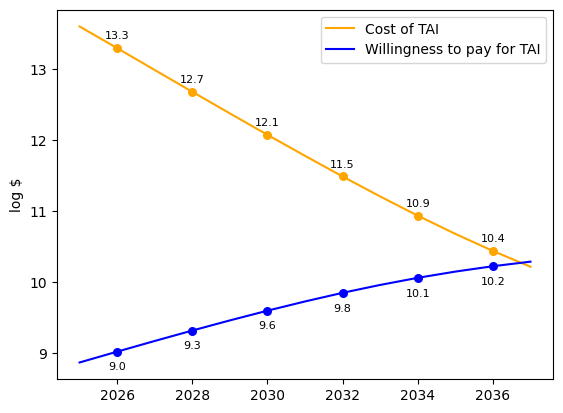

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 2.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~254.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~396.6 million).
* This doubles every 1.8 year to a max of 0.418384% of GDP (initially ~104.8 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 29.2 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 29.1 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 28.9 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 28.8 logFLOP which co

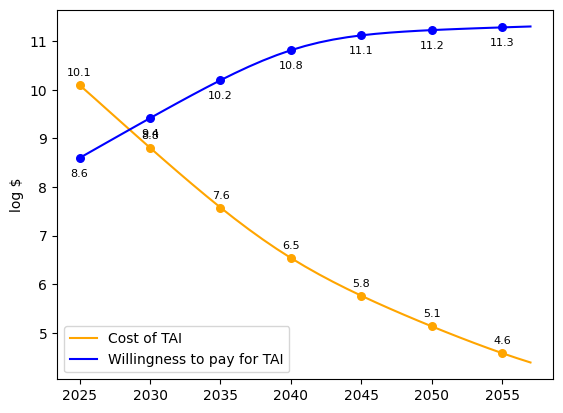

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 50.7 log FLOP (~501.2 quadrillion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5.0 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.5 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~816.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~302.7 million).
* This doubles every 1.6 year to a max of 0.028305% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 50.7 logFLOP which costs 31.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 50.4 logFLOP which costs 31.4 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 50.2 logFLOP which costs 31.0 log 2025$USD to buy vs. WTP at 8.8 (buys 28.0 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 49.9 log

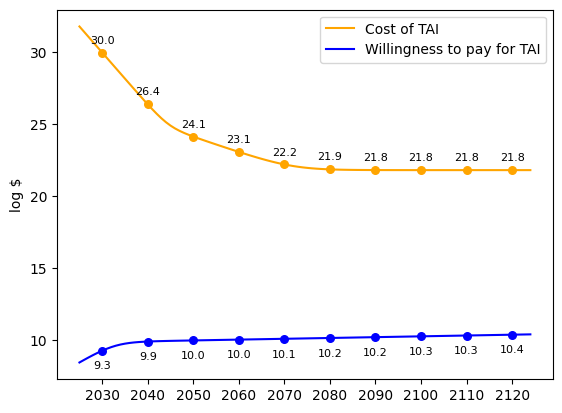

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.2 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~935.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.2 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 34.7 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 34.1 logFLOP which costs 14.7 log 2025$USD to buy vs. WTP at 9.2 (buys 28.6 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 33.8 logFLOP which costs 

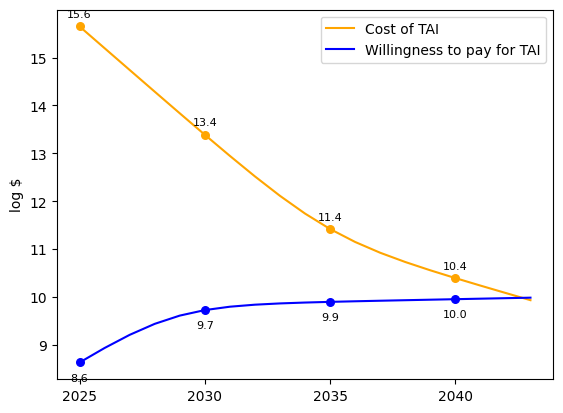

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~16.5 septillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~197.5 million).
* This doubles every 1.9 year to a max of 0.077592% of GDP (initially ~19.3 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 34.7 logFLOP which costs 16.2 log 2025$USD to buy vs. WTP at 8.5 (buys 26.9 log FLOP or 27.0 2025-log-eFLOP)
2027 - TAI takes 34.5 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2028 - TAI takes 34.4 logFLOP which cost

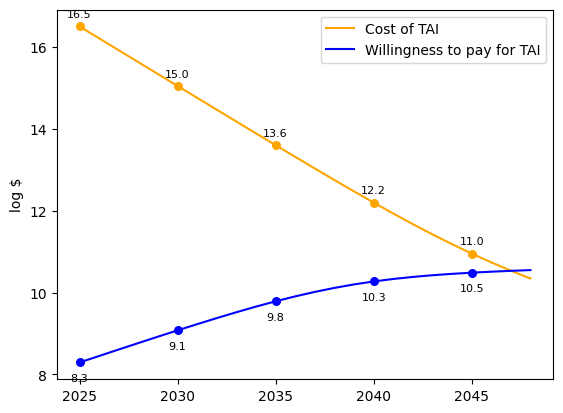

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.0 log 2025$USD (~99.0 million).
* This doubles every 0.9 year to a max of 0.039806% of GDP (initially ~10.0 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 26.0 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 8.0 (buys 26.3 log FLOP or 26.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 yea

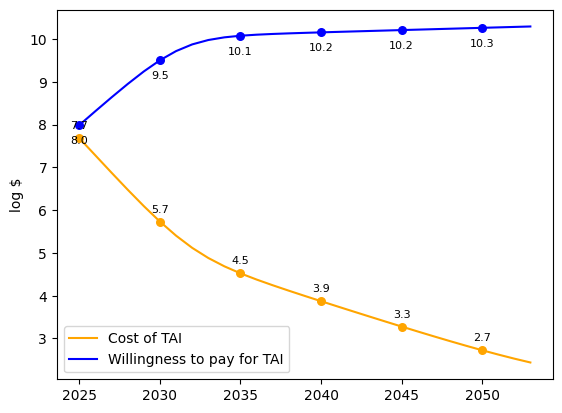

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 40.7 log FLOP (~50.1 million decillion) for transformative capabilities.
* Every 2.3 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.6 log FLOP (~35.7 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~27.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.8 log 2025$USD (~6.0 billion).
* This doubles every 1.6 year to a max of 0.05991% of GDP (initially ~15.0 billion 2025$USD).
* GDP grows at a rate of 1.01x per year.
---
2025 - TAI takes 40.7 logFLOP which costs 21.1 log 2025$USD to buy vs. WTP at 9.6 (buys 29.2 log FLOP or 29.2 2025-log-eFLOP)
2026 - TAI takes 40.6 logFLOP which costs 20.9 log 2025$USD to buy vs. WTP at 9.8 (buys 29.4 log FLOP or 29.5 2025-log-eFLOP)
2027 - TAI takes 40.4 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.9 (buys 29.6 log FLOP or 29.9 2025-log-eFLOP)
2028 - TAI takes 40.3 logFLOP which

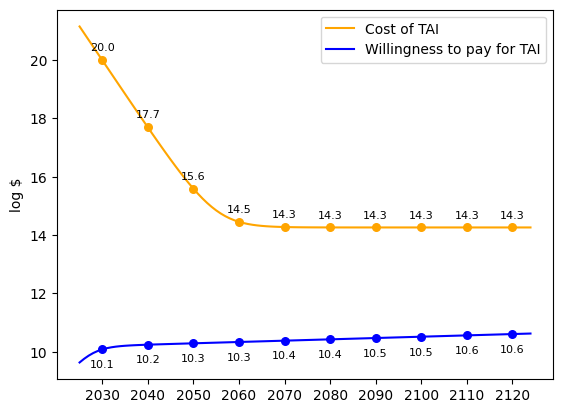

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 17.9 log FLOP (~800.4 quadrillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.3 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~309.0 million).
* This doubles every 1.5 year to a max of 0.053473% of GDP (initially ~13.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 8.5 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.9 log 2025$USD to buy vs. WTP at 8.7 (buys 26.7 log FLOP or 26.9 2025-log-eFLOP)
2027 - TAI takes 26.7 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.0 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2793 -

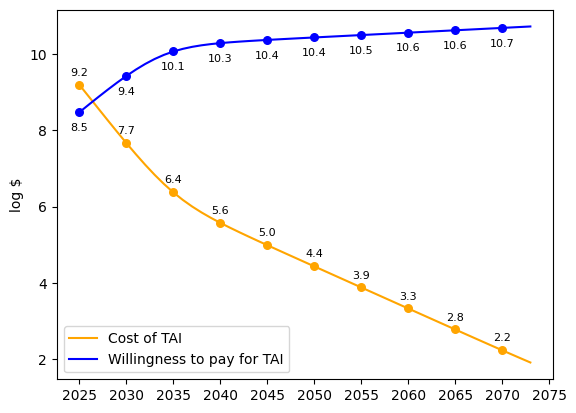

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 27.2 log FLOP (~1.6 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.4 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.5 sextillion) per 2025$USD.
* We are initially willing to pay 9.6 log 2025$USD (~3.9 billion).
* This doubles every 1.7 year to a max of 0.071605% of GDP (initially ~17.9 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 27.2 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -> No

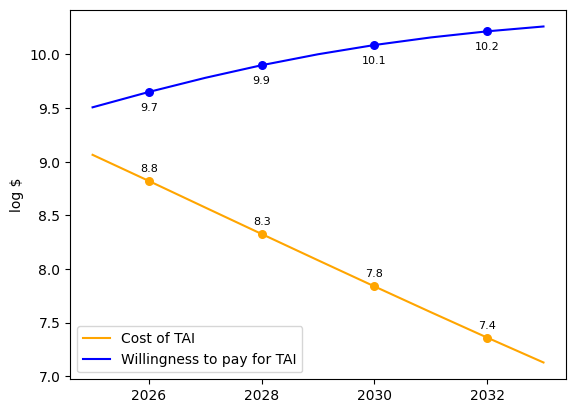

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.1 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.2 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.5 year to a max of 0.160508% of GDP (initially ~40.5 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 29.2 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 28.4 2025-log-eFLOP)
2026 - TAI takes 29.1 logFLOP which costs 9.7 log 2025$USD to buy vs. WTP at 9.4 (buys 28.7 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 28.9 logFLOP which costs 9.4 log 2025$USD to buy vs. WTP at 9.5 (buys 29.0 log FLOP or 29.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2793 ->

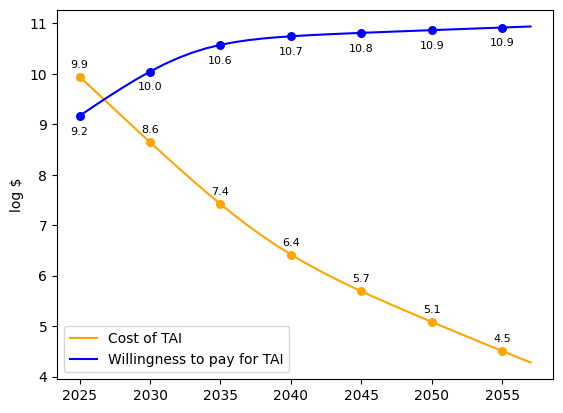

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 28.9 log FLOP (~79.4 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.7 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.7 log FLOP (~5.0 septillion) per 2025$USD.
* We are initially willing to pay 8.0 log 2025$USD (~99.8 million).
* This doubles every 1.2 year to a max of 0.170715% of GDP (initially ~42.5 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 28.9 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 8.0 (buys 26.7 log FLOP or 26.7 2025-log-eFLOP)
2026 - TAI takes 28.7 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 8.2 (buys 27.1 log FLOP or 27.2 2025-log-eFLOP)
2027 - TAI takes 28.6 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.8 2025-log-eFLOP)
2028 - TAI takes 28.4 logFLOP which costs 9.

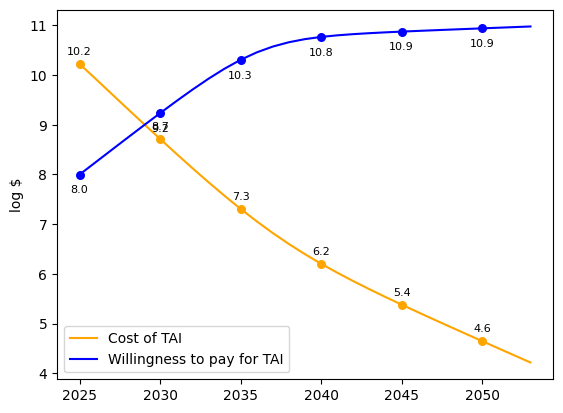

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.4 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~573.4 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 6 years)


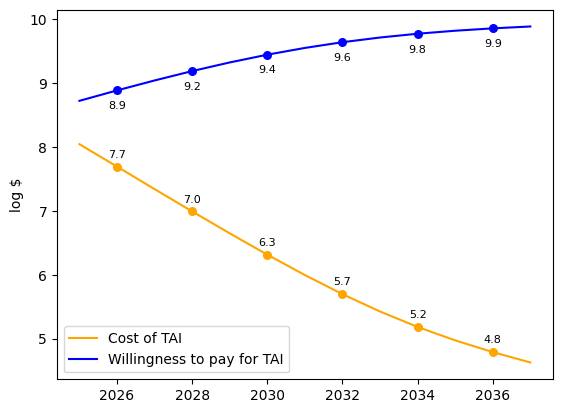

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 45.8 log FLOP (~6.3 trillion decillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.9 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~697.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.0 million).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 45.8 logFLOP which costs 26.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 45.6 logFLOP which costs 26.3 log 2025$USD to buy vs. WTP at 8.6 (buys 28.0 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 45.5 logFLOP which costs 26.0 log 2025$USD to buy vs. WTP at 8.8 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 45.3 logFLOP whic

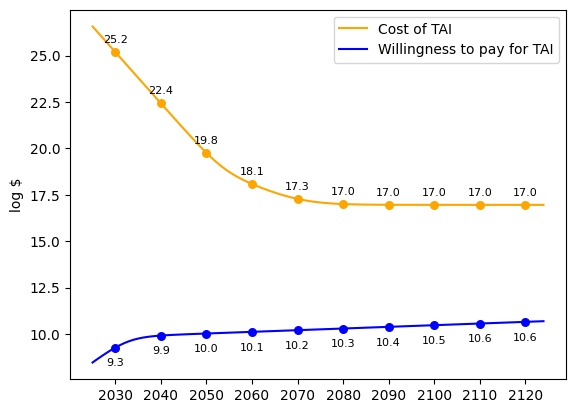

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 35.9 log FLOP (~794.3 decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 2.9 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~491.7 million).
* This doubles every 1.6 year to a max of 0.102633% of GDP (initially ~25.9 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 35.9 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.7 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 35.1 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 34.2 logFLOP which costs 14.9 log 2025$USD to buy vs. WTP at 9.0 (buys 28.4 log FLOP or 30.1 2025-log-eFLOP)
2028 - TAI takes 33.5 logFLOP which c

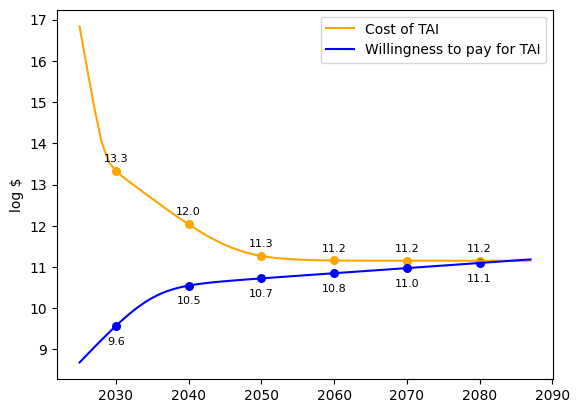

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.5 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 26.9 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.4 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 -> 

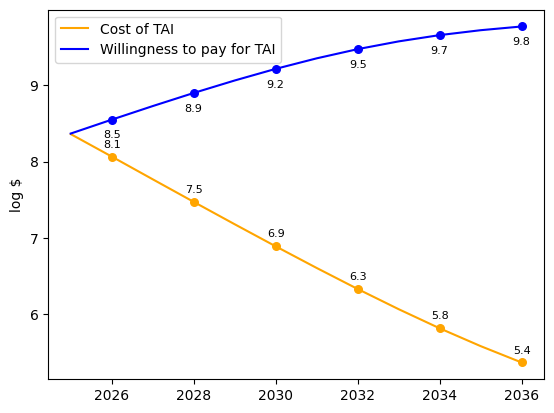

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 36.4 log FLOP (~2.5 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.2 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~376.3 million).
* This doubles every 4.0 year to a max of 0.027139% of GDP (initially ~6.9 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 36.4 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 35.9 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 35.3 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 34.8 logFLOP whic

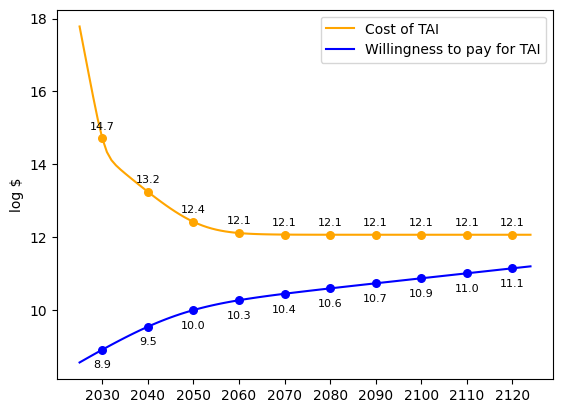

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 27.1 log FLOP (~1.3 octillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~214.8 sextillion) per 2025$USD.
* We are initially willing to pay 7.8 log 2025$USD (~63.0 million).
* This doubles every 2.3 year to a max of 0.16536% of GDP (initially ~41.4 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 27.1 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 7.8 (buys 26.4 log FLOP or 26.4 2025-log-eFLOP)
2026 - TAI takes 26.9 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 7.9 (buys 26.7 log FLOP or 26.9 2025-log-eFLOP)
2027 - TAI takes 26.7 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 27.3 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2793 -> 

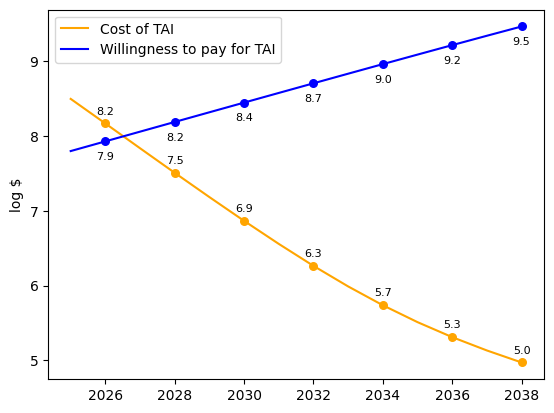

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 31.7 log FLOP (~50.1 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.3 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~431.6 sextillion) per 2025$USD.
* We are initially willing to pay 7.9 log 2025$USD (~79.3 million).
* This doubles every 2.4 year to a max of 0.222077% of GDP (initially ~55.7 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 31.7 logFLOP which costs 12.8 log 2025$USD to buy vs. WTP at 7.9 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 31.4 logFLOP which costs 12.4 log 2025$USD to buy vs. WTP at 8.0 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 31.1 logFLOP which costs 11.9 log 2025$USD to buy vs. WTP at 8.1 (buys 27.3 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 30.8 logFLOP which cost

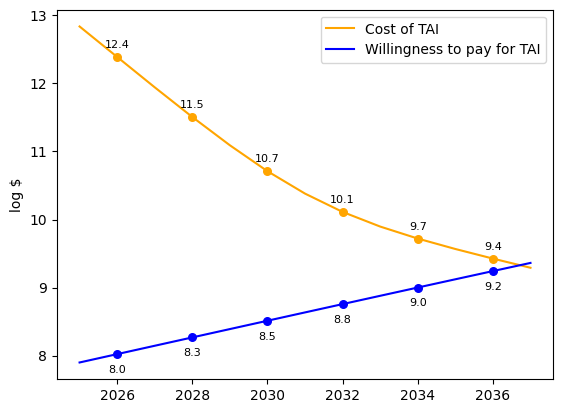

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 25.2 log FLOP (~15.8 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~26.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 1.0 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 25.2 logFLOP which costs 6.5 log 2025$USD to buy vs. WTP at 8.2 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur


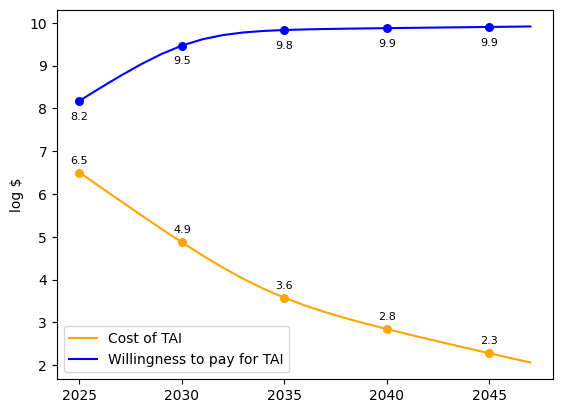

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 56.3 log FLOP (~199.5 sextillion decillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 4.2 log reductions possible.
* FLOP start at a cost of 19.5 log FLOP (~33.7 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~1.8 billion).
* This doubles every 2.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 56.3 logFLOP which costs 36.8 log 2025$USD to buy vs. WTP at 9.1 (buys 28.7 log FLOP or 28.7 2025-log-eFLOP)
2026 - TAI takes 56.1 logFLOP which costs 36.5 log 2025$USD to buy vs. WTP at 9.2 (buys 28.9 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 56.0 logFLOP which costs 36.2 log 2025$USD to buy vs. WTP at 9.3 (buys 29.1 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 55.8 logFLOP w

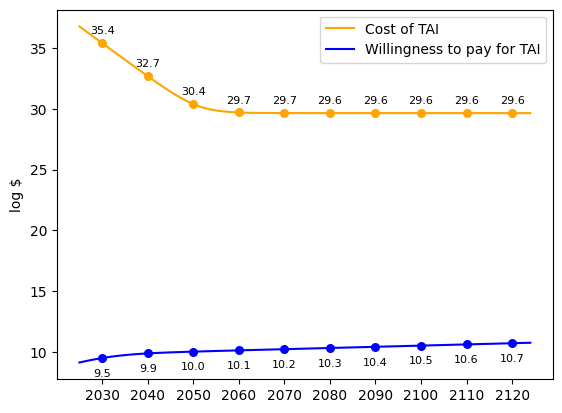

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 29.2 log FLOP (~158.5 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~268.3 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.1 billion).
* This doubles every 2.1 year to a max of 0.031748% of GDP (initially ~7.9 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 29.2 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 29.0 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 28.8 logFLOP which costs 10.0 log 2025$USD to buy vs. WTP at 9.2 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 28.6 logFLOP which costs

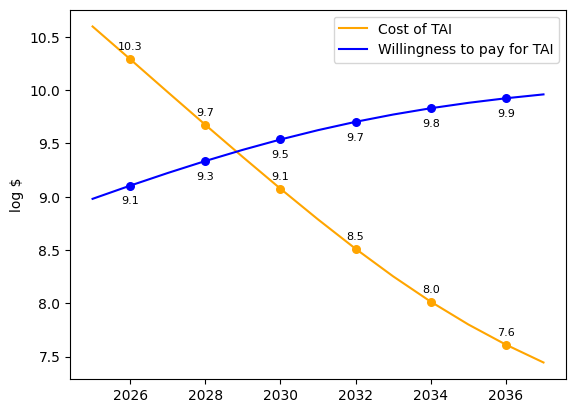

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 27.3 log FLOP (~2.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~8.6 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~861.2 million).
* This doubles every 1.2 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 27.3 logFLOP which costs 8.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling issue did not occur
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- robotics p_nonscaling_issue p=0.2707 -> Non

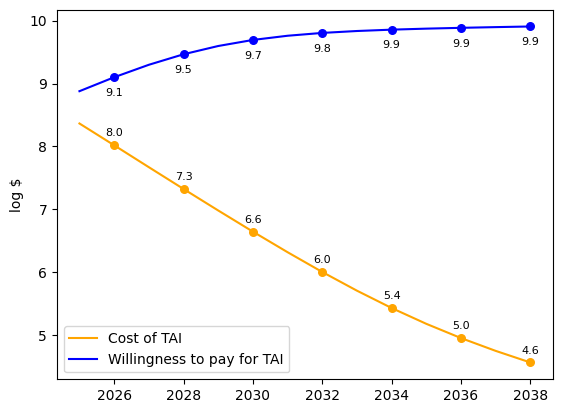

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 26.0 log FLOP (~100.0 septillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.1 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~576.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.4 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.029x per year.
---
2025 - TAI takes 26.0 logFLOP which costs 7.1 log 2025$USD to buy vs. WTP at 8.5 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707 ->

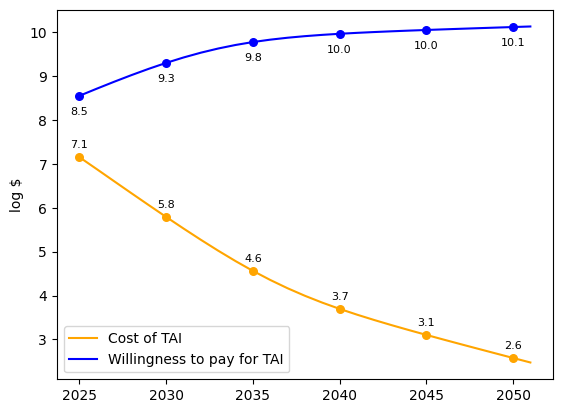

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~433.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.1 log 2025$USD (~123.4 million).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 24.0 logFLOP which costs 5.2 log 2025$USD to buy vs. WTP at 8.1 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 year

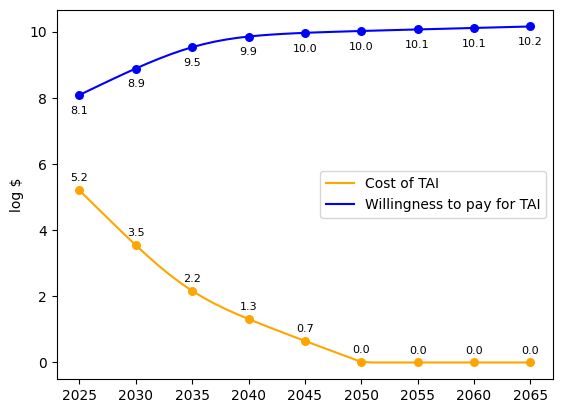

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 30.2 log FLOP (~1.6 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~254.3 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 2.0 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 30.2 logFLOP which costs 11.1 log 2025$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 29.9 logFLOP which costs 10.7 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 10.3 log 2025$USD to buy vs. WTP at 8.7 (buys 28.0 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which costs 9

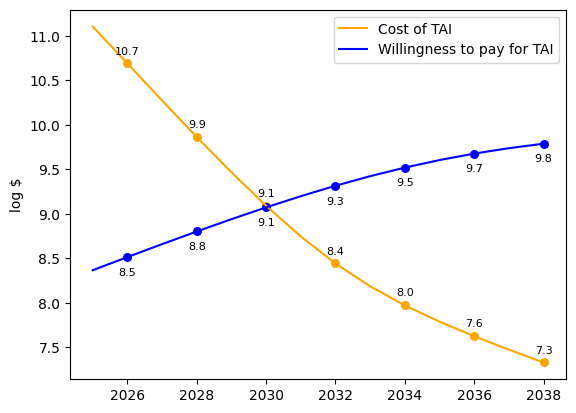

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 25.8 log FLOP (~63.1 septillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.7 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.5 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 25.8 logFLOP which costs 6.8 log 2025$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 6 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 6 years)
-

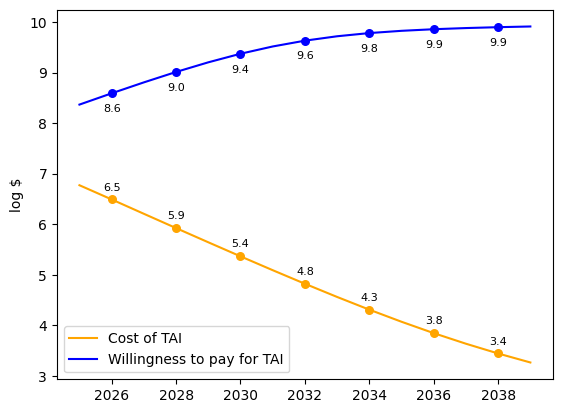

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 26.4 log FLOP (~251.2 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~4.0 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~78.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.0 million).
* This doubles every 1.8 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 26.4 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 1 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 6 years (total delay 8 years)

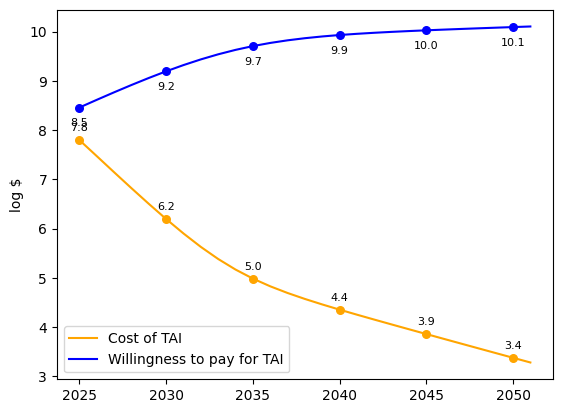

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.0 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.3 sextillion) per 2025$USD.
* We are initially willing to pay 7.8 log 2025$USD (~63.1 million).
* This doubles every 1.7 year to a max of 0.43414% of GDP (initially ~108.4 billion 2025$USD).
* GDP grows at a rate of 1.026x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 7.7 log 2025$USD to buy vs. WTP at 7.8 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 yea

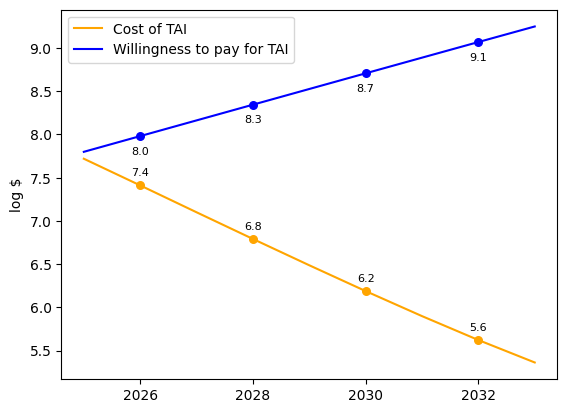

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 38.1 log FLOP (~125.9 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.2 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~390.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~863.2 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 38.1 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 8.9 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 37.8 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 9.1 (buys 28.3 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 37.5 logFLOP which costs 18.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.6 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 37.1 logFLOP whi

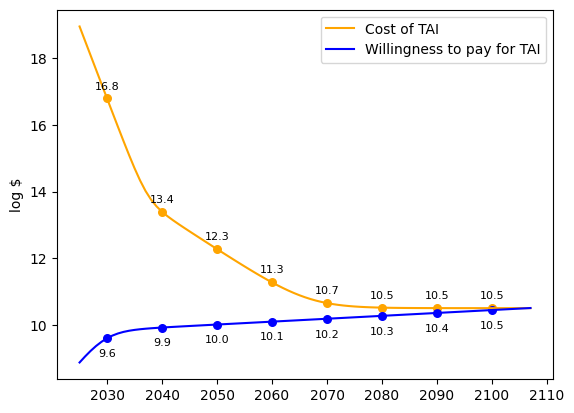

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 1.7 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.5 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~42.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~195.6 million).
* This doubles every 2.4 year to a max of 0.03963% of GDP (initially ~10.1 billion 2025$USD).
* GDP grows at a rate of 1.032x per year.
---
2025 - TAI takes 31.0 logFLOP which costs 12.0 log 2025$USD to buy vs. WTP at 8.3 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 30.8 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 30.7 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.5 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which cost

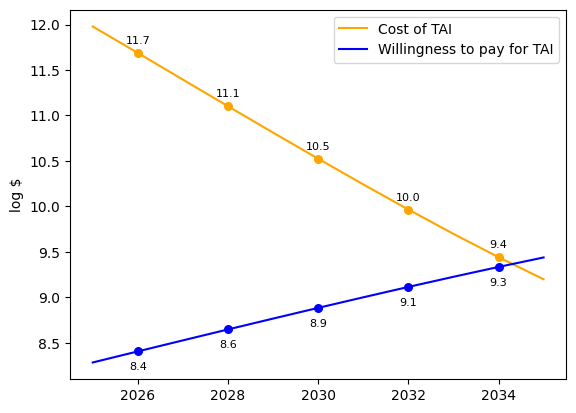

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 29.8 log FLOP (~631.0 octillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.6 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2.2 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~381.2 million).
* This doubles every 1.6 year to a max of 0.035852% of GDP (initially ~9.0 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 29.8 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 29.6 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.6 2025-log-eFLOP)
2027 - TAI takes 29.4 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 29.2 logFLOP which costs

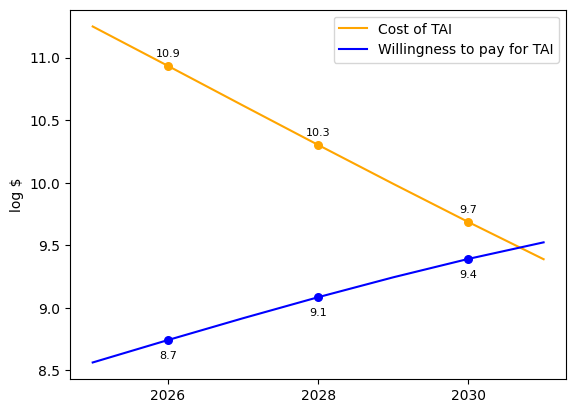

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 24.0 log FLOP (~1000.0 sextillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.5 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~394.4 million).
* This doubles every 1.8 year to a max of 0.167671% of GDP (initially ~41.9 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 24.0 logFLOP which costs 5.5 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.3 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.8 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.2707

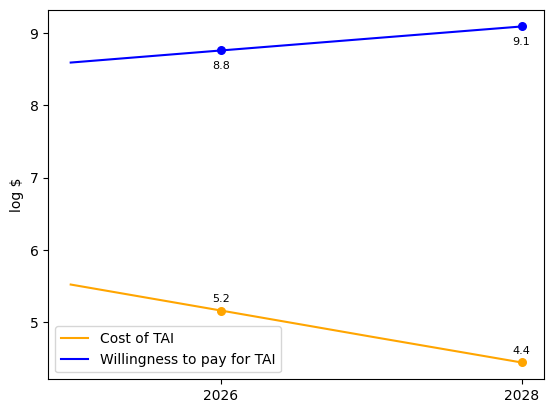

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 29.9 log FLOP (~794.3 octillion) for transformative capabilities.
* Every 1.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.6 log FLOP (~3.9 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~980.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.5 million).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 29.9 logFLOP which costs 11.3 log 2025$USD to buy vs. WTP at 8.4 (buys 27.0 log FLOP or 27.0 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 8.6 (buys 27.3 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 10.8 log 2025$USD to buy vs. WTP at 8.9 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which costs 

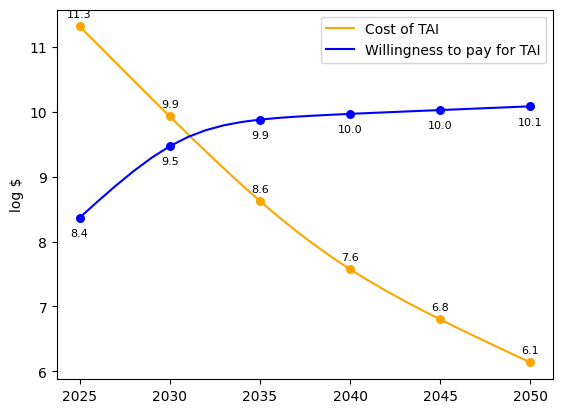

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 35.4 log FLOP (~251.2 decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.6 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~188.0 septillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~1.0 billion).
* This doubles every 2.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 35.4 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.0 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 35.1 logFLOP which costs 16.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 34.7 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 34.4 logFLOP which costs 15

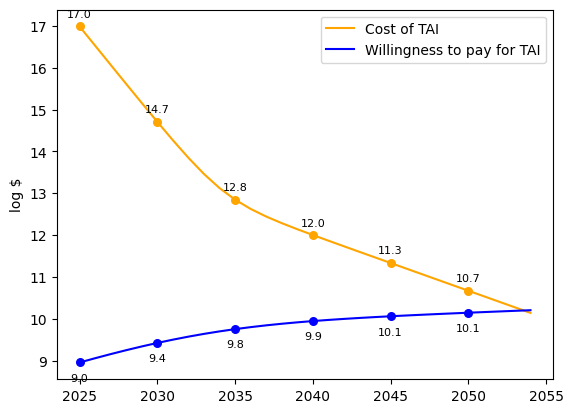

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-03-30 10:13:26.975635
